In [1]:
import numpy as np 
import pandas as pd 
import math
import seaborn as sns
import datetime as dt
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt


In [3]:
data = pd.read_csv('../MDB.csv')
data.head()

# Reset index
data.reset_index(drop=True, inplace=True)

# Select numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Fill NaN values in numeric columns with the mean of those columns
data[numeric_data.columns] = data[numeric_data.columns].fillna(numeric_data.mean())

# Display the first few rows of the DataFrame
print(data.head())

# Calculate moving average
ma_day = [5, 10, 20, 50]  # Common short-term and long-term windows
for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Close'].rolling(window=ma).mean()

# Calculate Exponential moving average
for ma in ma_day:
    column_name = f"EMA for {ma} days"
    data[column_name] = data['Close'].ewm(span=ma, adjust=False).mean()

# Volatility (Standard Deviation): Capture price fluctuations:
# for ma in ma_day:
#     column_name = f"Volatility_{ma}d"
#     data[column_name] = data['Close'].rolling(window=ma).std()

# Calculate RSI
def compute_RSI(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

data['RSI_14'] = compute_RSI(data)

# # Trading Volume Moving Average: Add moving averages for the Volume
# for ma in ma_day:
#     data[f"Volume_MA_{ma}"] = data['Volume'].rolling(window=ma).mean()

data.dropna(inplace=True)
data.head(500)

         Date   Open   High     Low  Close    Volume
0  2017-10-19  33.00  34.00  29.100  32.07  11508466
1  2017-10-20  33.37  33.37  30.100  30.68   2358653
2  2017-10-23  30.51  31.33  30.190  30.50    749397
3  2017-10-24  30.46  30.92  30.439  30.57    420725
4  2017-10-25  30.50  31.10  29.880  31.00   1219442


,Date,Open,High,Low,Close,Volume,MA for 5 days,MA for 10 days,MA for 20 days,MA for 50 days,EMA for 5 days,EMA for 10 days,EMA for 20 days,EMA for 50 days,RSI_14
49,2017-12-29,30.35,30.3900,29.5200,29.68,324587,29.254,29.022,28.1060,29.2480,29.414513,29.026543,28.775329,29.299191,64.871017
50,2018-01-02,29.93,30.0800,28.8550,29.25,231621,29.414,29.005,28.1785,29.1916,29.359676,29.067172,28.820536,29.297262,59.552358
51,2018-01-03,29.31,29.4200,28.9400,29.15,256707,29.484,29.090,28.2680,29.1610,29.289784,29.082231,28.851913,29.291487,50.716332
52,2018-01-04,29.29,29.4900,28.9000,29.05,198884,29.474,29.190,28.4130,29.1320,29.209856,29.076371,28.870779,29.282017,59.529148
53,2018-01-05,29.09,29.1350,28.5900,29.05,205632,29.236,29.145,28.5220,29.1016,29.156571,29.071576,28.887848,29.272918,55.651106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,2019-12-18,129.29,132.3900,128.5600,129.18,1059895,128.794,129.470,137.4205,131.6157,129.554616,131.005356,132.953574,133.502397,27.692308
545,2019-12-19,130.60,132.9000,128.5700,130.96,861351,130.040,129.429,136.5810,131.5655,130.023077,130.997109,132.763710,133.402695,31.071276
546,2019-12-20,131.25,132.6899,129.6600,130.68,836492,130.494,129.380,135.7915,131.5297,130.242052,130.939453,132.565261,133.295923,40.591023
547,2019-12-23,130.75,133.2900,130.1100,132.36,641720,130.514,129.515,135.0135,131.4507,130.948034,131.197734,132.545713,133.259220,34.024768


Text(0, 0.5, 'Closing price')

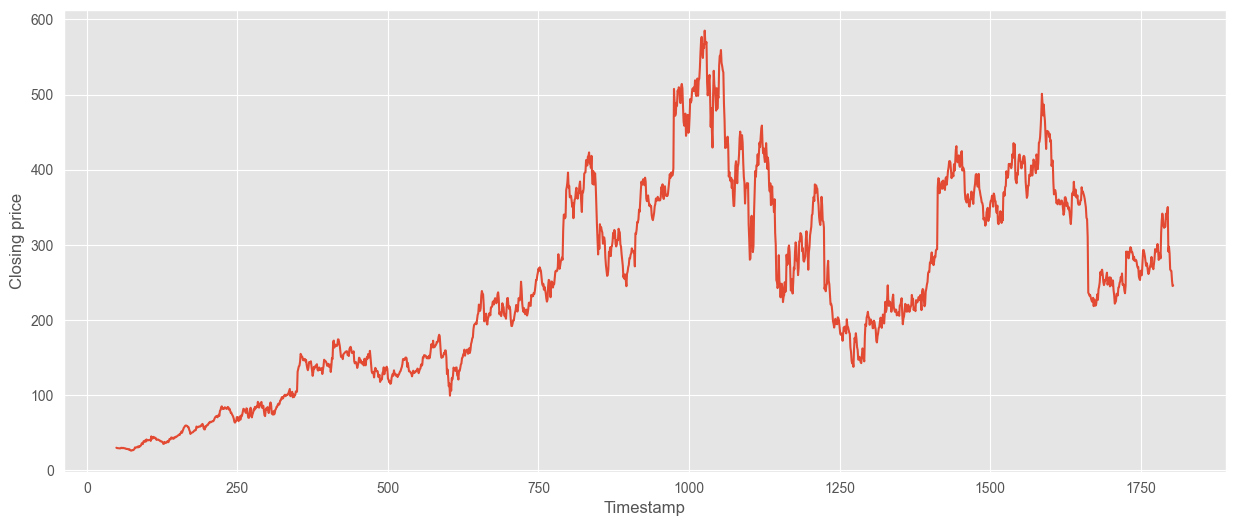

In [5]:
# plot the full dataset

plt.figure(figsize=(15, 6))
plt.plot(data['Close'], label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")




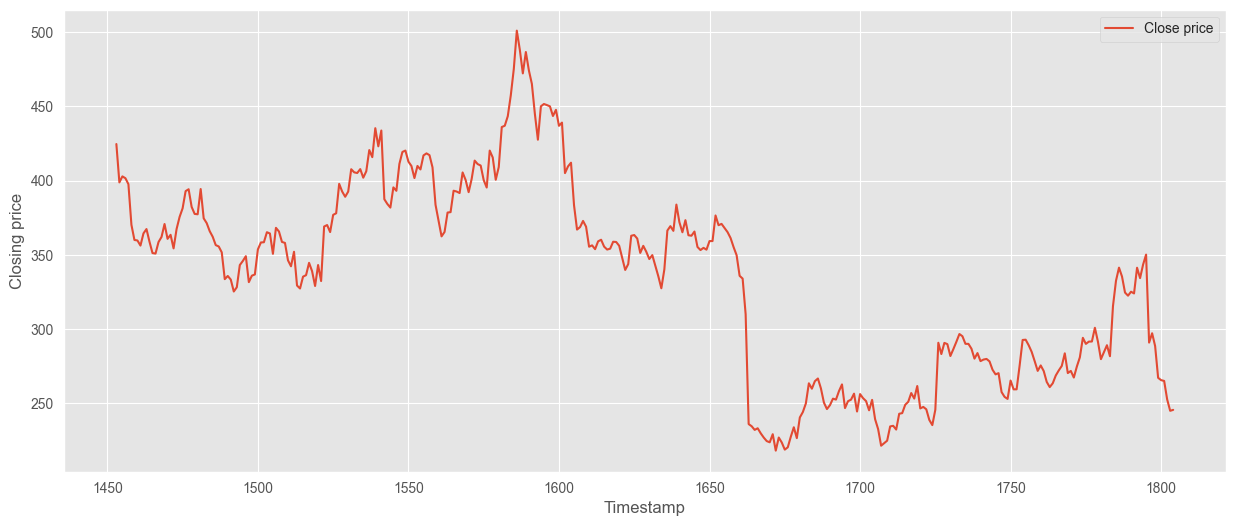

In [6]:
# Plot the last 20% of the data

plt.figure(figsize=(15, 6))
last_20_percent = data['Close'].iloc[int(len(data) * 0.8):]
plt.plot(last_20_percent.index, last_20_percent.values, label="Close price")
plt.xlabel("Timestamp")
plt.ylabel("Closing price")
plt.legend()

In [8]:
from xgboost import XGBRegressor


feature_columns = [
    'Close',          # Most important feature (direct price information)
    'Low',            # Important price-related feature
    'High',           # Important price-related feature
    'Open',           # Important price-related feature
    'EMA for 5 days', # Short-term trend indicator
    'MA for 5 days',  # Short-term trend indicator
    'RSI_14'          # Momentum indicator
]

X = data[feature_columns].values
y = data['Close'].values

print("Total dataset shape:", X.shape)

# Calculate split point (80% training, 20% validation)
split_idx = int(len(X) * 0.8)

# Split the data chronologically for XGBoost
X_train_xgb = X[:split_idx]
X_val_xgb = X[split_idx:]
y_train_xgb = y[:split_idx]
y_val_xgb = y[split_idx:]

# Scale the data after splitting to prevent data leakage
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_train_scaled = feature_scaler.fit_transform(X_train_xgb)
X_val_scaled = feature_scaler.transform(X_val_xgb)  # Only transform, don't fit
y_train_scaled = target_scaler.fit_transform(y_train_xgb.reshape(-1, 1))
y_val_scaled = target_scaler.transform(y_val_xgb.reshape(-1, 1))  # Only transform, don't fit

print("XGBoost Training set shape:", X_train_scaled.shape)
print("XGBoost Validation set shape:", X_val_scaled.shape)

# Train XGBoost model
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train_scaled)

# Make predictions on both train and validation sets
xgb_train_predictions = xgb_model.predict(X_train_scaled)
xgb_val_predictions = xgb_model.predict(X_val_scaled)

# For combining with LSTM later, stack the predictions back together
xgb_predictions = np.concatenate([xgb_train_predictions, xgb_val_predictions])

# Combine features with XGBoost predictions
X_train_combined = np.column_stack((X_train_scaled, xgb_train_predictions))
X_val_combined = np.column_stack((X_val_scaled, xgb_val_predictions))
combined_features = np.vstack((X_train_combined, X_val_combined))

# Create sequences for LSTM
sequence_length = 30
X_sequences = []
y_sequences = []

for i in range(len(combined_features) - sequence_length):
    X_sequences.append(combined_features[i:(i + sequence_length)])
    y_sequences.append(combined_features[i + sequence_length, -1])  # Take only the target variable

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# Calculate split point (80% training, 20% validation)
split_idx = int(len(X_sequences) * 0.8)

# Split data chronologically for LSTM
X_train = X_sequences[:split_idx]
X_val = X_sequences[split_idx:]
y_train = y_sequences[:split_idx]
y_val = y_sequences[split_idx:]

print("LSTM Training set shape:", X_train.shape)
print("LSTM Validation set shape:", X_val.shape)

Total dataset shape: (1756, 7)
XGBoost Training set shape: (1404, 7)
XGBoost Validation set shape: (352, 7)
LSTM Training set shape: (1380, 30, 8)
LSTM Validation set shape: (346, 30, 8)


In [9]:
# Load the saved model and parameters
def load_lstm_model(model_path='xgboost_lstm_model.h5', params_path='xgboost_lstm_params.json'):
    # Load the model
    lstm_model = load_model(model_path)
    
    # Load the sequence length
    with open(params_path, 'r') as f:
        params = json.load(f)
    
    print(f"Model loaded from {model_path}")
    return lstm_model, params['sequence_length']

In [10]:
import json
from tensorflow.keras.models import load_model

# Load the model
loaded_model, seq_length = load_lstm_model()

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'xgboost_lstm_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [31]:
# Make predictions
lstm_predictions = loaded_model.predict(X_sequences)
final_predictions = target_scaler.inverse_transform(lstm_predictions)


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.metrics import explained_variance_score, mean_poisson_deviance, mean_gamma_deviance
from sklearn.metrics import r2_score
from sklearn.metrics import max_error


# Get actual values
actual_values = y[sequence_length:]

# Calculate the split point for the last 20% of the data
split_idx = int(len(actual_values) * 0.8)

# Get only the validation portion (last 20%)
val_actual = actual_values[split_idx:]
val_predictions = final_predictions[split_idx:]

# Calculate metrics on validation set only
mse = mean_squared_error(val_actual, val_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(val_actual, val_predictions)
r2 = r2_score(val_actual, val_predictions)

print("\nPerformance Metrics:")
print(f"MSE: {mse:.2f}")
print(f"RMSE:{rmse:.2f} ")
print(f"MAE: {mae:.2f} ")
print(f"R2 Score: {r2:.4f} ")



Performance Metrics:
MSE: 1451.26
RMSE:38.10 
MAE: 32.49 
R2 Score: 0.6567 


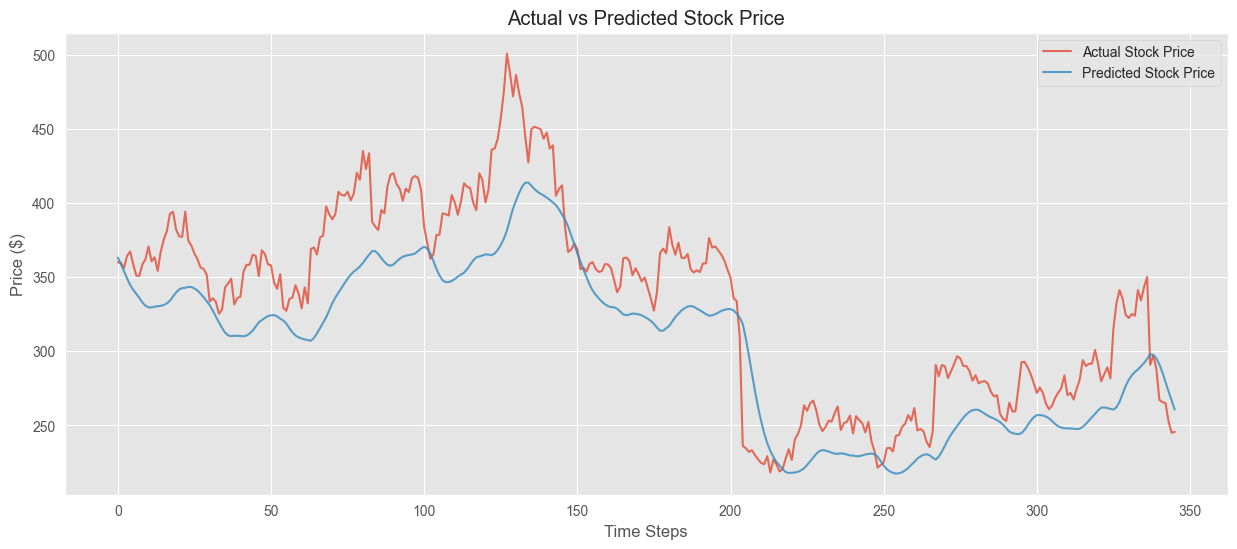

In [33]:


# Plot only the results
plt.figure(figsize=(15, 6))
plt.plot(val_actual, label='Actual Stock Price', alpha=0.8)
plt.plot(val_predictions, label='Predicted Stock Price', alpha=0.8)
plt.title('Actual vs Predicted Stock Price')
plt.xlabel('Time Steps')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()

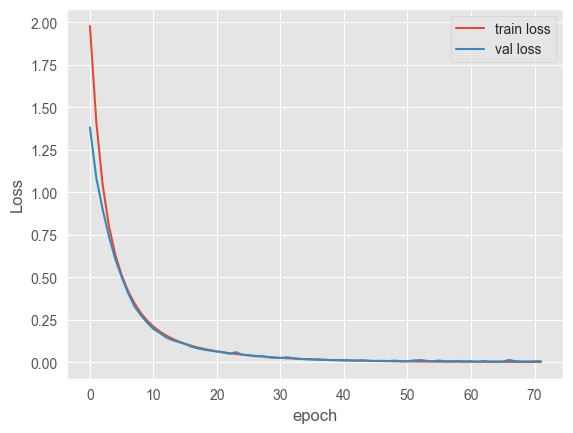

In [8]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()



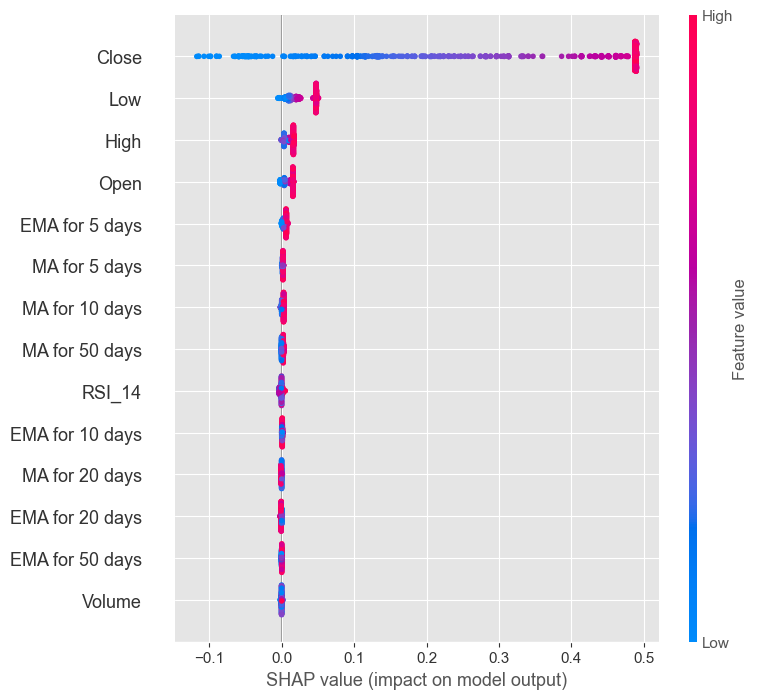

In [34]:
import shap

# Create a SHAP explainer
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_val_scaled)

# Plot SHAP summary
shap.summary_plot(shap_values, X_val_scaled, feature_names=feature_columns)